# Translational profiling in *M. acetivorans* - Tollerson et al. 2024

This notebook presents the usage of the translational profiler tool developed in support of the analyses presented in [Tollerson et al. LINK](). Note that this notebook only includes the ribosomal footprint data processing and analyses, the pre-processing of raw fastq files and differential abundance analyses for transcript data are presented elsewhere


In [1]:
import glob
import re
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt

from translational_profiler import *  # the whole thing

These files are not in the repository due to size but should be available from supplementary data / following the scripts for the upstream analysis steps

In [3]:
%load_ext autoreload
%autoreload 2

# paths to input files
af='ribo_seq/acetivorans/nt_files/acetivorans.gff'
fa='ribo_seq/acetivorans/nt_files/acetivorans_genome.fa'

tma='ribo_seq/acetivorans/mapping/bam/tma_merged.bam'
meoh='ribo_seq/acetivorans/mapping/bam/meoh_merged.bam'
tx_tma='rna_seq/mapped_mRNA/bam/merged/TMA.sorted.bam'
tx_meoh='rna_seq/mapped_mRNA/bam/merged/MeOH.sorted.bam'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{26: 158301, 25: 183453, 22: 42727, 28: 56079, 19: 7028, 23: 99754, 32: 2148, 17: 4347, 29: 27933, 30: 17422, 24: 130855, 27: 134259, 20: 10559, 18: 27850, 21: 18746, 31: 5698, 33: 446, 16: 581, 35: 66, 36: 22, 37: 9, 34: 153, 15: 106, 39: 5, 38: 5, 14: 2, 40: 1}


{26: 158301,
 25: 183453,
 22: 42727,
 28: 56079,
 19: 7028,
 23: 99754,
 32: 2148,
 17: 4347,
 29: 27933,
 30: 17422,
 24: 130855,
 27: 134259,
 20: 10559,
 18: 27850,
 21: 18746,
 31: 5698,
 33: 446,
 16: 581,
 35: 66,
 36: 22,
 37: 9,
 34: 153,
 15: 106,
 39: 5,
 38: 5,
 14: 2,
 40: 1}

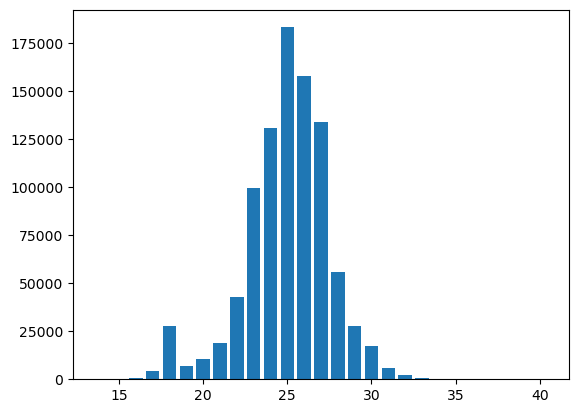

In [4]:
# read count distribution

readDist(bamfile=tma, verbose=True)

only M...* genes
Only showing reads from genes with rpkm > 50
only M...* genes
Only showing reads from genes with rpkm > 50
only M...* genes
Only showing reads from genes with rpkm > 50
only M...* genes
Only showing reads from genes with rpkm > 50


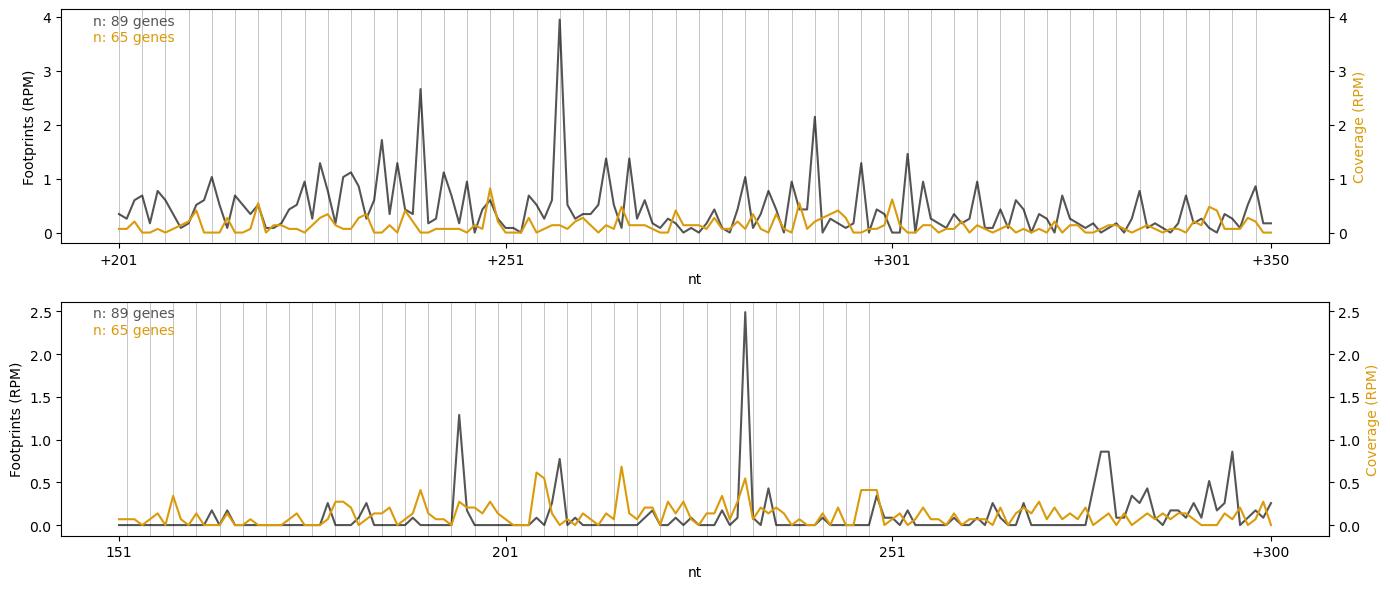

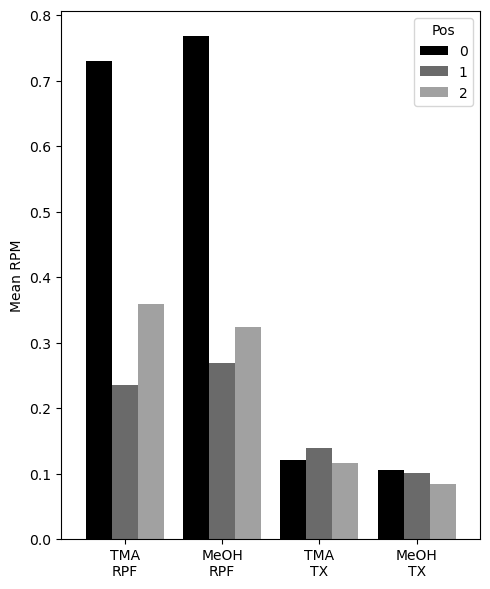

In [9]:
## no 3nt periodicity for txome

ann = read_prodigal(af)
ann = checkGeneSpacing(ann, window=500)
ann = ann.loc[(ann.stop - ann.start) > 500]

skipnt = 251 # multiple of 3 ( - 1 if greater than window)

tx_tma1, tx_tma2 = metagene(bamfile=tx_tma, annfile=ann, window=50, footprint_size=122, offset=0, codon_resolved=True,
                       rpm=True, geneposoffset=skipnt, minrpm=50, fasta_path=fa)

tx_meoh1, tx_meoh2 = metagene(bamfile=tx_meoh, annfile=ann, window=50, footprint_size=122, offset=0, codon_resolved=True,
                       rpm=True, geneposoffset=skipnt, minrpm=50, fasta_path=fa)

tma1, tma2 = metagene(bamfile=tma, annfile=ann, window=50, footprint_size=24, offset=0, codon_resolved=True,
                       rpm=True, geneposoffset=skipnt, minrpm=50, fasta_path=fa)

meoh1, meoh2 = metagene(bamfile=meoh, annfile=ann, window=50, footprint_size=24, offset=0, codon_resolved=True,
                       rpm=True, geneposoffset=skipnt, minrpm=50, fasta_path=fa)


plot_metagene(covs_start=tma1, covs_stop=tma2, bg_start=tx_tma1, bg_stop=tx_tma2, window=50, axis_units='RPM',
             bg_fill=False, colors=['#000000aa','#da9a0a'], geneposoffset=skipnt, norenorm=True)
plt.tight_layout()
#plt.savefig('figs/Fig2a_triplet_tma.pdf')


fig, ax = plt.subplots(1,1, figsize=(5,6))
d = pd.DataFrame({'Pos':np.tile([0,1,2],50), 
              'TMA\nRPF':tma1[:,:].mean(axis=1),
             'MeOH\nRPF':meoh1[:,:].mean(axis=1),
             'TMA\nTX':tx_tma1[:,:].mean(axis=1),
             'MeOH\nTX':tx_meoh1[:,:].mean(axis=1)}).groupby('Pos').mean()

d.transpose().plot.bar(ax=ax, width=0.8, color=['black','#6a6a6a','#A1A1A1'])
plt.xticks(rotation=0)
plt.ylabel('Mean RPM')
plt.tight_layout()
#plt.savefig('figs/Fig2c_triplet_summary.pdf')


Direction of region: -
Direction of region: -


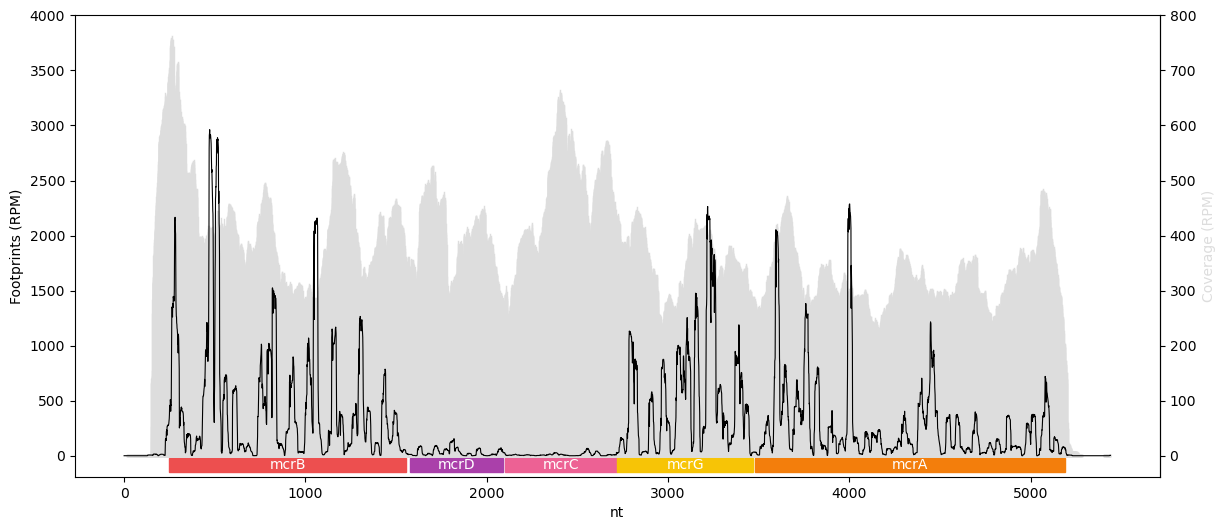

In [9]:
# Search for specific genes
search='mcr'

plot_genes(search, bamfile=tma, annfile=af, txfile=tx_tma, window=250, 
          codon_resolved=False, footprint_size=24, rpm=True, axis_units='RPM', moving_average=0,
           cols=['#ed4f4fff','#aa40aaff','#ed6194ff','#f7c406ff','#f37e0cff'], 
           genelabs=['mcrB','mcrD','mcrC','mcrG','mcrA'])
#plt.savefig('figs/Fig3A_mcr_tma.pdf')

In [8]:
# using helper functions for ratios

ann = read_prodigal(af)

rpf_counts = featureCounts(bamfile=tma, annfile=ann.loc[ann.tags.str.contains('mcr')], rpkm=True).counts
tx_counts = featureCounts(bamfile=tx_tma, annfile=ann.loc[ann.tags.str.contains('mcr')], rpkm=True).counts

print('on negative strand, not flipped')
print((rpf_counts/tx_counts)/min(rpf_counts/tx_counts))

on negative strand, not flipped
9667    38.924937
9669    59.293162
9671     1.000000
9673     3.373910
9675    48.867653
Name: counts, dtype: float64


Direction of region: -
Direction of region: -


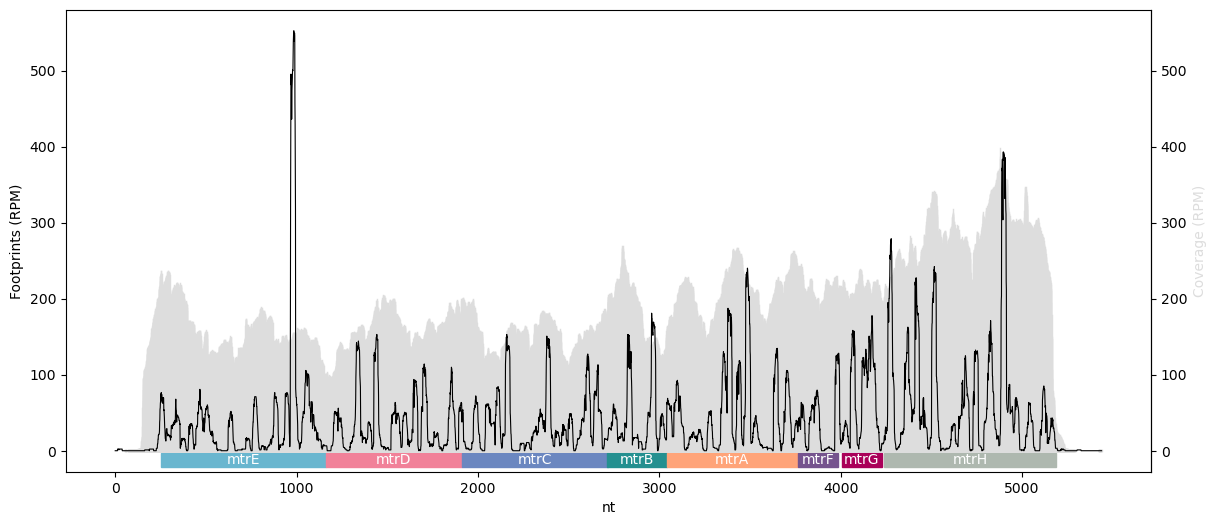

In [10]:
search='tetrahydromethanopterin'#'mtr[A-Z]'

mtr = read_prodigal(af)
mtr = mtr.loc[mtr.tags.str.contains(search)][1:9]  # keep only the operon
labs = [re.sub('^.*(mtr[A-Z]).*$','\\1', x) for x in mtr.tags][::-1]  # genes on negative strand
labs[3] = 'mtrB'  # simplify messy annotation

plot_genes(search, bamfile=tma, annfile=mtr, txfile=tx_tma, window=250, 
          codon_resolved=False, footprint_size=24, rpm=True, axis_units='RPM',
              cols=['#69b6cfff','#f18199ff','#6b87c0ff','#249090ff','#ffa479ff','#75538eff','#aa0059ff','#aeb8afff'], 
           genelabs=labs)

#plt.savefig('figs/Fig3B_mtr_tma.pdf')
#plt.savefig('figs/Fig3B_mtr_tma.png')

only M...* genes
only M...* genes
Only showing reads with rpm > 50
only M...* genes
Only showing reads with rpm > 50
only M...* genes
Only showing reads with rpm > 50
only M...* genes
Only showing reads with rpm > 50
only M...* genes
Only showing reads with rpm > 50
only M...* genes
Only showing reads with rpm > 50
only M...* genes
Only showing reads with rpm > 50
only M...* genes
Only showing reads with rpm > 50


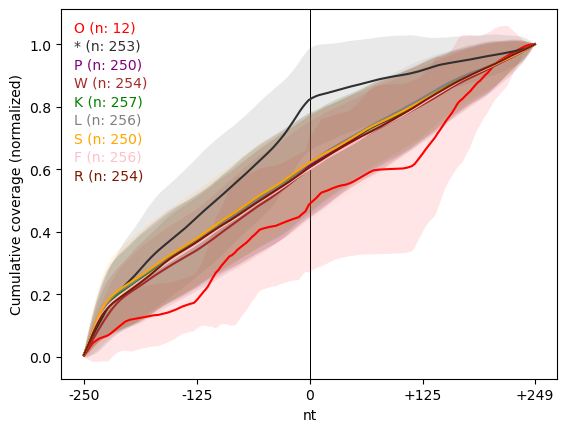

In [20]:
## Pyl is not a stop
w=250  # window around each codon

residues = {}
for codon in ['O','*','P','W','K','L','S','F','R']:
    if codon == 'O':
        minrpm=0
    else:
        minrpm=50
    pre, post = codonhalves(tma, af, fasta_path=fa, codon=codon, rpm=True, minrpm=minrpm, codon_resolved=False, normalgenes=True)
    residues[codon] = codonslice(pre, post, window=w)
    
plotPrePostAA(residues, window=w, n_best=250, traces=False)

#plt.savefig('Fig6B_pyl.pdf')